## dataload

In [64]:
import mlflow
import mlflow.lightgbm
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import pandas as pd
import os
import random
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
from eli5.sklearn import PermutationImportance
from shap import TreeExplainer, Explanation
from shap.plots import waterfall
from utils import custom_train_test_split, lgbm_predict, post_slack, title2filename
os.environ["LOGNAME"]='cwj'
SEED=13

## 1. 데이터 로딩
data_dir = '/opt/ml/input/data' # 경로
after_fe_path = os.path.join(data_dir, 'base_lgbm2.pkl')
df = pd.read_pickle(after_fe_path)

train_df = df[df.kind=='train']
train, valid1, valid2 = custom_train_test_split(train_df, ratio=0.7, seed=SEED) # 훈련데이터 split
test = df[df.kind=='test'] # 테스트 데이터
train2 = test[test.answerCode!=-1] # 테스트데이터 마지막 제출 2번쨰꺼까지 훈련데이터로 사용
train = pd.concat([train,train2]) # 훈련데이터 병합
train.shape, valid1.shape, valid2.shape, test.shape

x_train = train.drop('answerCode',axis=1)
y_train = train[['answerCode']]

x_valid1 = valid1.drop('answerCode',axis=1)
y_valid1 = valid1[['answerCode']]

x_valid2 = valid2.drop('answerCode',axis=1)
y_valid2 = valid2[['answerCode']]

x_train.shape, y_train.shape, x_valid1.shape, y_valid1.shape, x_valid2.shape, y_valid2.shape

((1845539, 87), (680417, 87), (1974, 87), (260114, 87))

((1845539, 86), (1845539, 1), (680417, 86), (680417, 1), (1974, 86), (1974, 1))

In [65]:
df[:3]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,kind,uidIdx,assIdx,testIdx,...,mid_category_solvesec_o,mid_category_solvesec_x,problem_count,tag_count,RepeatedTime,prior_KnowledgeTag_frequency,problem_position,solve_order,retest,solved_disorder
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,train,0,5354,975,...,470.865257,374.856236,7,2,0.000000,0,0.142857,1,0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,train,0,5355,975,...,470.865257,374.856236,7,2,1.386294,0,0.285714,2,0,0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,train,0,5356,975,...,470.865257,374.856236,7,2,2.197225,1,0.428571,3,0,0


## LGBM 학습 및 예측

In [70]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day',
       'hour', 'dayname', 'big_category', 'problem_num', 'mid_category',
       'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum',
       'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category',
       'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut',
       'big_category_answer', 'big_category_user_cum_acc',
       'big_category_cum_solvesec', 'big_category_mean_solvesec',
       'mid_category_cumconut', 'mid_category_answer',
       'mid_category_user_cum_acc', 'mid_category_cum_solvesec',
       'mid_category_mean_solvesec', 'problem_num_cumconut',
       'problem_num_answer', 'problem_num_user_cum_acc',
       'problem_num_cum_solvesec', 'problem_num_mean_solvesec', 'ass_acc_mean',
       'ass_acc_sum', 'ass_difficult

([0, 1, 2, 3, 6, 7, 8, 9, 11, 20, 22],
 '🌈(12/08 Thu)[LGBM ass acc mean, pb_num_acc_mean 피처 2개 추가 lr 0.023] 피처: 39개',
 '사용된 피처(39)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, test_mean, test_sum, test_std, tag_mean, tag_sum, tag_std, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, big_category_answer, big_category_cum_solvesec, big_category_mean_solvesec, mid_category_cumconut, mid_category_user_cum_acc, assess_count, elo_assessmentItemID, elo_problem_num, ass_solvesec, ass_solvesec_o, ass_solvesec_x, problem_num_solvesec, problem_num_solvesec_o, problem_num_solvesec_x')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21538
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.818314
[200]	valid_0's auc: 0.822803
[300]	valid_0's auc: 0.82525
[400]	valid_0's auc: 0.82704
[500]	valid_0's auc: 0.828192
[600]	valid_0's auc: 0.829182
[700]	valid_0's auc: 0.829881
[800]	valid_0's auc: 0.830479
[900]	valid_0's auc: 0.831112
[1000]	valid_0's auc: 0.831711
[1100]	valid_0's auc: 0.832212
[1200]	valid_0's auc: 0.832295
[1300]	valid

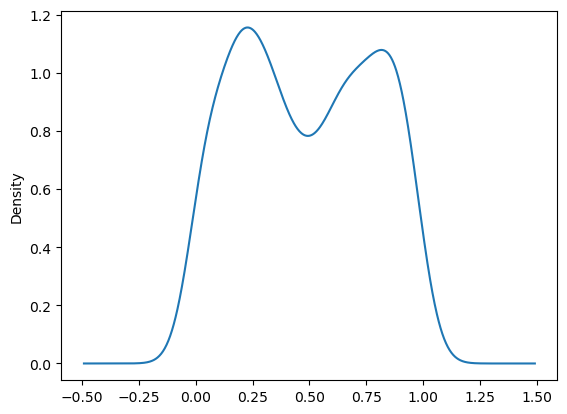

In [72]:
FEATS = ['uidIdx','assIdx','testIdx','KnowledgeTag',
 'user_correct_answer','user_total_answer',
 'month','day','dayname','hour',
 'test_mean','test_sum','test_std',
 'tag_mean','tag_sum','tag_std',
 'solvesec_3600','time_category',
 'solvesec_cumsum','solvecumsum_category',
 'big_category',
 'big_category_cumconut','big_category_user_cum_acc','big_category_answer',
 'big_category_cum_solvesec','big_category_mean_solvesec',
 'mid_category',
 'mid_category_cumconut','mid_category_user_cum_acc',
 'assess_count',
 'elo_assessmentItemID','elo_problem_num',
 'ass_solvesec','ass_solvesec_o','ass_solvesec_x',
 'problem_num',
 'problem_num_solvesec','problem_num_solvesec_o','problem_num_solvesec_x']

# Hyper parameter 설정
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "dart",  # dart
    "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
    "metric": "auc",
}

### 피처 설정
# 사용할 Feature 설정


cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM ass acc mean, pb_num_acc_mean 피처 2개 추가 lr 0.023] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid1 = lgb.Dataset(x_valid1[FEATS], y_valid1)
lgb_x_valid2 = lgb.Dataset(x_valid2[FEATS], y_valid2)

with mlflow.start_run(run_name=title, description=desc) as run:
    model = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid2], # [lgb_x_valid1, lgb_x_valid2],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
#     preds1 = model.predict(x_valid1[FEATS])
    preds2 = model.predict(x_valid2[FEATS])
    acc = accuracy_score(y_valid2, np.where(preds2 >= 0.5, 1, 0))
#     auc1 = roc_auc_score(y_valid1, preds1)
    auc2 = roc_auc_score(y_valid2, preds2)
#     print(f'VALID1 AUC : {auc1}, VALID2 AUC : {auc2}, ACC : {acc}\n')
    print(f'VALID AUC : {auc2}, ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc2)
    mlflow.log_metric("VAL Set SEED",SEED)
    model_run_id=run.info.run_id
    post_slack("done")
    print(f"{model_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

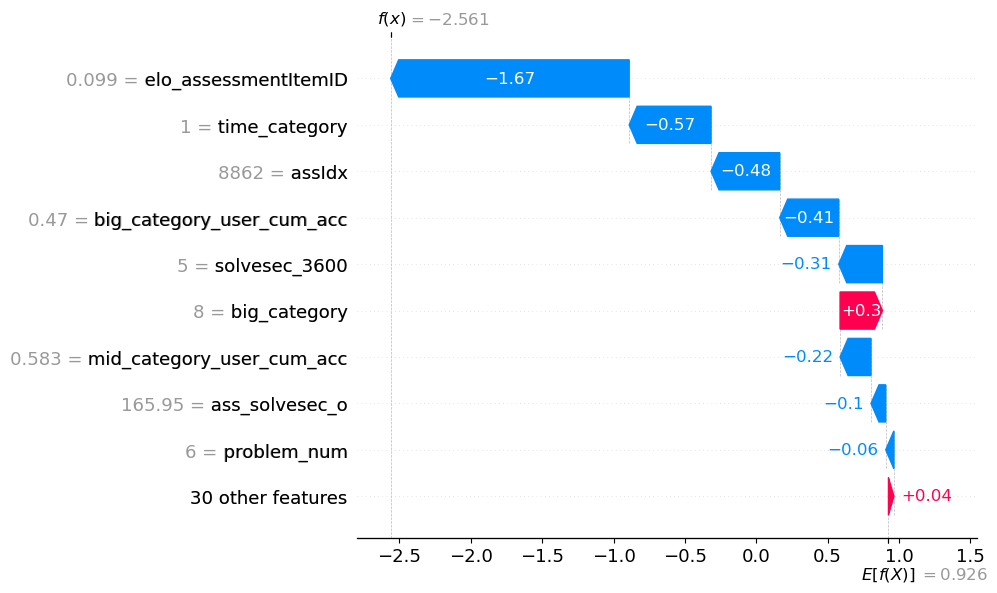

In [75]:
explainer = TreeExplainer(model)
sv = explainer(x_valid2[FEATS])
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=x_valid2[FEATS].values, 
                  feature_names=FEATS)
idx = 0
waterfall(exp[idx])
# perm = PermutationImportance(
#     model, scoring="roc_auc", n_iter=1, random_state=42, cv=None, refit=False
# ).fit(x_valid2[FEATS], y_valid2)
# eli5.show_weights(perm, top=len(FEATS), feature_names=FEATS)

In [79]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day',
       'hour', 'dayname', 'big_category', 'problem_num', 'mid_category',
       'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum',
       'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category',
       'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut',
       'big_category_answer', 'big_category_user_cum_acc',
       'big_category_cum_solvesec', 'big_category_mean_solvesec',
       'mid_category_cumconut', 'mid_category_answer',
       'mid_category_user_cum_acc', 'mid_category_cum_solvesec',
       'mid_category_mean_solvesec', 'problem_num_cumconut',
       'problem_num_answer', 'problem_num_user_cum_acc',
       'problem_num_cum_solvesec', 'problem_num_mean_solvesec', 'ass_acc_mean',
       'ass_acc_sum', 'ass_difficult

In [ ]:
FEATS = ['uidIdx','assIdx','testIdx','KnowledgeTag',
 'user_correct_answer','user_total_answer',
 'month','day','dayname','hour',
 'test_mean','test_sum','test_std',
 'tag_mean','tag_sum','tag_std',
 'solvesec_3600','time_category',
 'solvesec_cumsum','solvecumsum_category',
 'big_category',
 'big_category_cumconut','big_category_user_cum_acc','big_category_answer',
 'big_category_cum_solvesec','big_category_mean_solvesec',
 'mid_category',
 'mid_category_cumconut','mid_category_user_cum_acc',
 'assess_count',
 'elo_assessmentItemID','elo_problem_num',
 'ass_solvesec','ass_solvesec_o','ass_solvesec_x',
 'problem_num',
 'problem_num_solvesec','problem_num_solvesec_o','problem_num_solvesec_x']

In [ ]:
[i for i in df.columns if i not in FEATS]

([0, 1, 2, 3, 6, 8, 17, 19, 20, 29, 38],
 '🌈(12/08 Thu)[LGBM big category solvesec 관련 피처 3개 추가 lr 0.023] 피처: 42개',
 '사용된 피처(42)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, month, day, dayname, hour, test_mean, test_sum, test_std, tag_mean, tag_sum, tag_std, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category, big_category_cumconut, big_category_user_cum_acc, big_category_answer, big_category_cum_solvesec, big_category_mean_solvesec, bg_category_solvesec, bg_category_solvesec_o, bg_category_solvesec_x, mid_category, mid_category_cumconut, mid_category_user_cum_acc, assess_count, elo_assessmentItemID, elo_problem_num, ass_solvesec, ass_solvesec_o, ass_solvesec_x, problem_num, problem_num_solvesec, problem_num_solvesec_o, problem_num_solvesec_x')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21568
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.818849
[200]	valid_0's auc: 0.823157
[300]	valid_0's auc: 0.82525
[400]	valid_0's auc: 0.826877
[500]	valid_0's auc: 0.828236
[600]	valid_0's auc: 0.828993
[700]	valid_0's auc: 0.829694
[800]	valid_0's auc: 0.830111
[900]	valid_0's auc: 0.83064
[1000]	valid_0's auc: 0.831326
[1100]	valid_0's auc: 0.831732
[1200]	valid_0's auc: 0.832033
[1300]	valid

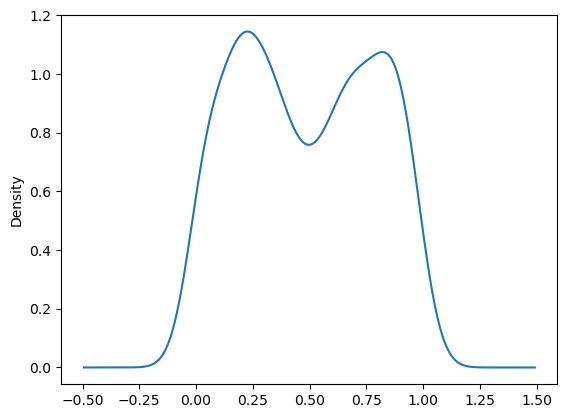

In [84]:
FEATS = ['uidIdx','assIdx','testIdx','KnowledgeTag',
 'user_correct_answer','user_total_answer',
 'month','day','dayname','hour',
 'test_mean','test_sum','test_std',
 'tag_mean','tag_sum','tag_std',
 'solvesec_3600', 'time_category',
 'solvesec_cumsum', 'solvecumsum_category',
 'big_category',
 'big_category_cumconut', 'big_category_user_cum_acc', 'big_category_answer',
 'big_category_cum_solvesec', 'big_category_mean_solvesec',
 'bg_category_solvesec', 'bg_category_solvesec_o', 'bg_category_solvesec_x',
 'mid_category',
 'mid_category_cumconut', 'mid_category_user_cum_acc',
 'assess_count',
 'elo_assessmentItemID','elo_problem_num',
 'ass_solvesec', 'ass_solvesec_o', 'ass_solvesec_x',
 'problem_num',
 'problem_num_solvesec','problem_num_solvesec_o','problem_num_solvesec_x']

# Hyper parameter 설정
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "dart",  # dart
    "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
    "metric": "auc",
}

### 피처 설정
# 사용할 Feature 설정


cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM big category solvesec 관련 피처 3개 추가 lr 0.023] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid1 = lgb.Dataset(x_valid1[FEATS], y_valid1)
lgb_x_valid2 = lgb.Dataset(x_valid2[FEATS], y_valid2)

with mlflow.start_run(run_name=title, description=desc) as run:
    model = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid2], # [lgb_x_valid1, lgb_x_valid2],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
#     preds1 = model.predict(x_valid1[FEATS])
    preds2 = model.predict(x_valid2[FEATS])
    acc = accuracy_score(y_valid2, np.where(preds2 >= 0.5, 1, 0))
#     auc1 = roc_auc_score(y_valid1, preds1)
    auc2 = roc_auc_score(y_valid2, preds2)
#     print(f'VALID1 AUC : {auc1}, VALID2 AUC : {auc2}, ACC : {acc}\n')
    print(f'VALID AUC : {auc2}, ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc2)
    mlflow.log_metric("VAL Set SEED",SEED)
    model_run_id=run.info.run_id
    post_slack("done")
    print(f"{model_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

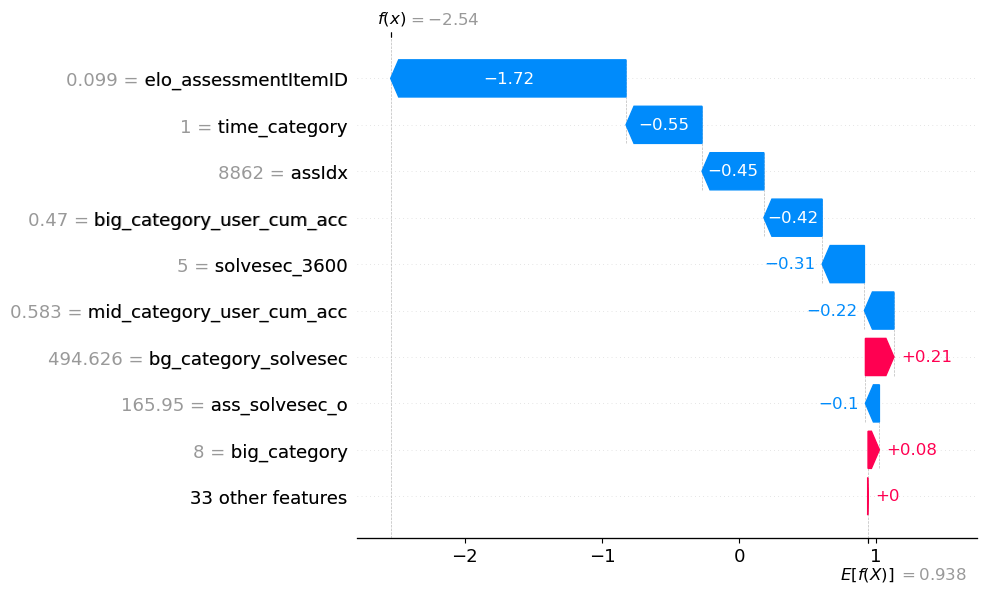

In [86]:
explainer = TreeExplainer(model)
sv = explainer(x_valid2[FEATS])
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=x_valid2[FEATS].values, 
                  feature_names=FEATS)
idx = 0
waterfall(exp[idx])
# perm = PermutationImportance(
#     model3, scoring="roc_auc", n_iter=1, random_state=42, cv=None, refit=False
# ).fit(x_valid2[FEATS], y_valid2)
# eli5.show_weights(perm, top=len(FEATS), feature_names=FEATS)

In [93]:
FEATS = ['uidIdx','assIdx','testIdx','KnowledgeTag',
 'user_correct_answer','user_total_answer',
 'month','day','dayname','hour',
 'test_mean','test_sum','test_std',
 'tag_mean','tag_sum','tag_std',
 'solvesec_3600', 'time_category',
 'solvesec_cumsum', 'solvecumsum_category',
 'big_category',
 'big_category_cumconut', 'big_category_user_cum_acc', 'big_category_answer',
 'big_category_cum_solvesec', 'big_category_mean_solvesec',
 'bg_category_solvesec', 'bg_category_solvesec_o', 'bg_category_solvesec_x',
 'mid_category',
 'mid_category_cumconut', 'mid_category_user_cum_acc',
 'assess_count',
 'elo_assessmentItemID','elo_problem_num',
 'ass_solvesec', 'ass_solvesec_o', 'ass_solvesec_x',
 'problem_num',
 'problem_num_solvesec','problem_num_solvesec_o','problem_num_solvesec_x']

In [94]:
[i for i in df.columns if i not in FEATS]

['userID',
 'assessmentItemID',
 'testId',
 'answerCode',
 'Timestamp',
 'kind',
 'user_acc',
 'Timestamp2',
 'solvetime',
 'solvesec',
 'mid_category_answer',
 'mid_category_cum_solvesec',
 'mid_category_mean_solvesec',
 'problem_num_cumconut',
 'problem_num_answer',
 'problem_num_user_cum_acc',
 'problem_num_cum_solvesec',
 'problem_num_mean_solvesec',
 'ass_acc_mean',
 'ass_acc_sum',
 'ass_difficulty',
 'ass_acc_std',
 'pb_num_acc_mean',
 'pb_num_acc_sum',
 'pb_num_difficulty',
 'pb_num_acc_std',
 'left_asymptote',
 'hour_mean',
 'hour_sum',
 'dayname_mean',
 'dayname_sum',
 'tag_solvesec',
 'tag_solvesec_o',
 'tag_solvesec_x',
 'mid_category_solvesec',
 'mid_category_solvesec_o',
 'mid_category_solvesec_x',
 'problem_count',
 'tag_count',
 'RepeatedTime',
 'prior_KnowledgeTag_frequency',
 'problem_position',
 'solve_order',
 'retest',
 'solved_disorder']

([0, 1, 2, 3, 6, 8, 17, 19, 20, 29, 37],
 '🌈(12/08 Thu)[LGBM pbnum acc 피처 3개 추가 lr 0.023] 피처: 49개',
 '사용된 피처(49)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, month, day, dayname, hour, test_mean, test_sum, test_std, tag_mean, tag_sum, tag_std, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category, big_category_cumconut, big_category_user_cum_acc, big_category_answer, big_category_cum_solvesec, big_category_mean_solvesec, bg_category_solvesec, bg_category_solvesec_o, bg_category_solvesec_x, mid_category, mid_category_cumconut, mid_category_user_cum_acc, assess_count, elo_assessmentItemID, ass_solvesec, ass_solvesec_o, ass_solvesec_x, problem_num, pb_num_acc_sum, pb_num_difficulty, pb_num_acc_std, problem_num_cumconut, problem_num_answer, problem_num_user_cum_acc, problem_num_solvesec, problem_num_solvesec_o, problem_num_solvesec_x, problem_num_cum_solvesec, problem_num_mean_solvesec')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22607
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.817788
[200]	valid_0's auc: 0.822867
[300]	valid_0's auc: 0.82512
[400]	valid_0's auc: 0.826961
[500]	valid_0's auc: 0.828259
[600]	valid_0's auc: 0.829286
[700]	valid_0's auc: 0.829933
[800]	valid_0's auc: 0.830821
[900]	valid_0's auc: 0.831577
[1000]	valid_0's auc: 0.832208
[1100]	valid_0's auc: 0.832946
[1200]	valid_0's auc: 0.833237
[1300]	vali

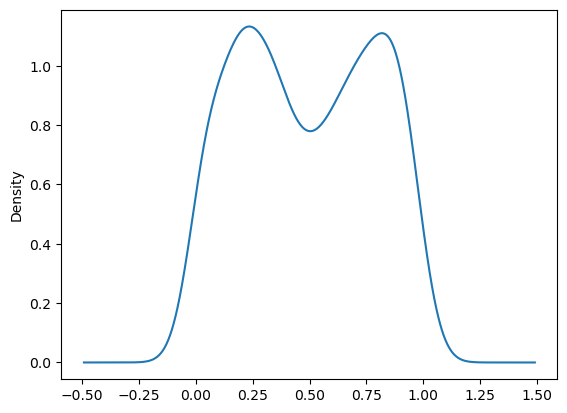

In [96]:
FEATS = ['uidIdx','assIdx','testIdx','KnowledgeTag',
 'user_correct_answer','user_total_answer',
 'month','day','dayname','hour',
 'test_mean','test_sum','test_std',
 'tag_mean','tag_sum','tag_std',
 'solvesec_3600', 'time_category',
 'solvesec_cumsum', 'solvecumsum_category',
 'big_category',
 'big_category_cumconut', 'big_category_user_cum_acc', 'big_category_answer',
 'big_category_cum_solvesec', 'big_category_mean_solvesec',
 'bg_category_solvesec', 'bg_category_solvesec_o', 'bg_category_solvesec_x',
 'mid_category',
 'mid_category_cumconut', 'mid_category_user_cum_acc',
 'assess_count',
 'elo_assessmentItemID',
 'ass_solvesec', 'ass_solvesec_o', 'ass_solvesec_x',
 'problem_num',
 'pb_num_acc_sum','pb_num_difficulty','pb_num_acc_std',
 'problem_num_cumconut', 'problem_num_answer', 'problem_num_user_cum_acc',
 'problem_num_solvesec','problem_num_solvesec_o','problem_num_solvesec_x',
 'problem_num_cum_solvesec','problem_num_mean_solvesec',
]

# Hyper parameter 설정
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "dart",  # dart
    "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
    "metric": "auc",
}

### 피처 설정
# 사용할 Feature 설정
cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측
date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM pbnum acc 피처 3개 추가 lr 0.023] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid1 = lgb.Dataset(x_valid1[FEATS], y_valid1)
lgb_x_valid2 = lgb.Dataset(x_valid2[FEATS], y_valid2)

with mlflow.start_run(run_name=title, description=desc) as run:
    model3 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid2], # [lgb_x_valid1, lgb_x_valid2],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
#     preds1 = model3.predict(x_valid1[FEATS])
    preds2 = model3.predict(x_valid2[FEATS])
    acc = accuracy_score(y_valid2, np.where(preds2 >= 0.5, 1, 0))
#     auc1 = roc_auc_score(y_valid1, preds1)
    auc2 = roc_auc_score(y_valid2, preds2)
#     print(f'VALID1 AUC : {auc1}, VALID2 AUC : {auc2}, ACC : {acc}\n')
    print(f'VALID AUC : {auc2}, ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc2)
    mlflow.log_metric("VAL Set SEED",SEED)
    model3_run_id=run.info.run_id
    post_slack("done")
    print(f"{model3_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model3, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

## 피처 추가

In [52]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day',
       'hour', 'dayname', 'big_category', 'problem_num', 'mid_category',
       'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum',
       'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category',
       'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut',
       'big_category_answer', 'big_category_user_cum_acc',
       'big_category_solvesec', 'big_category_mean_solvesec',
       'mid_category_cumconut', 'mid_category_answer',
       'mid_category_user_cum_acc', 'mid_category_solvesec_x_x',
       'mid_category_mean_solvesec', 'ass_acc_mean', 'ass_acc_sum',
       'ass_difficulty', 'ass_acc_std', 'pb_num_acc_mean', 'pb_num_acc_sum',
       'pb_num_difficulty', 'pb_num_acc_std', 'assess_count', 'left_asymptote',
       'elo_a

([0, 1, 2, 3, 6, 7, 9, 21, 22, 28],
 '🌈(12/08 Thu)[LGBM timcategory 제거 lr 0.023] 피처: 46개',
 '사용된 피처(46)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, problem_num, month, day, dayname, hour, test_mean, test_sum, test_std, tag_mean, tag_sum, tag_std, ass_acc_mean, ass_acc_sum, solvesec_3600, solvesec_cumsum, solvecumsum_category, big_category, big_category_cumconut, big_category_user_cum_acc, big_category_answer, big_category_solvesec, big_category_mean_solvesec, mid_category, mid_category_cumconut, mid_category_user_cum_acc, assess_count, elo_assessmentItemID, elo_problem_num, ass_solvesec, ass_solvesec_o, ass_solvesec_x, pb_num_acc_mean, problem_num_mean_solvesec, problem_count, problem_num_solvesec, problem_num_solvesec_o, problem_num_solvesec_x, solve_order, solved_disorder, RepeatedTime')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22833
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.819539
[200]	valid_0's auc: 0.824278
[300]	valid_0's auc: 0.827071
[400]	valid_0's auc: 0.828689
[500]	valid_0's auc: 0.829323
[600]	valid_0's auc: 0.829425
[700]	valid_0's auc: 0.829815
[800]	valid_0's auc: 0.830199
[900]	valid_0's auc: 0.830313
[1000]	valid_0's auc: 0.830384
[1100]	valid_0's auc: 0.830606
[1200]	valid_0's auc: 0.830825
[1300]	val

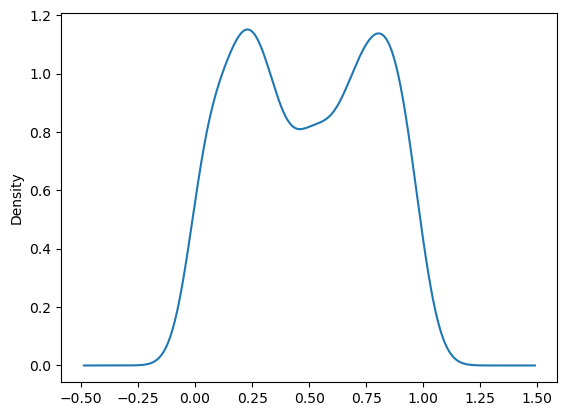

In [59]:
FEATS = [
         'uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer', 'user_total_answer',
         'problem_num',
         'month','day','dayname','hour',
         'test_mean', 'test_sum','test_std',
         'tag_mean', 'tag_sum', 'tag_std',
         'ass_acc_mean', 'ass_acc_sum',
         'solvesec_3600',
         'solvesec_cumsum', 'solvecumsum_category',
         'big_category',
         'big_category_cumconut','big_category_user_cum_acc', 'big_category_answer',
         'big_category_solvesec', 'big_category_mean_solvesec',
         'mid_category',
         'mid_category_cumconut', 'mid_category_user_cum_acc',
         'assess_count',
         'elo_assessmentItemID',
         'elo_problem_num',
         'ass_solvesec', 'ass_solvesec_o', 'ass_solvesec_x',
         'pb_num_acc_mean', 'problem_num_mean_solvesec', 'problem_count',
         'problem_num_solvesec', 'problem_num_solvesec_o','problem_num_solvesec_x',
         'solve_order', 'solved_disorder', 'RepeatedTime'
        ]

# Hyper parameter 설정
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "dart",  # dart
    "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
    "metric": "auc",
}

### 피처 설정
# 사용할 Feature 설정


cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM timcategory 제거 lr 0.023] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\nFEATS='{using_feats}'.split(', ')]"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid1 = lgb.Dataset(x_valid1[FEATS], y_valid1)
lgb_x_valid2 = lgb.Dataset(x_valid2[FEATS], y_valid2)

with mlflow.start_run(run_name=title, description=desc) as run:
    model4 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid2], # [lgb_x_valid1, lgb_x_valid2],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
#     preds1 = model4.predict(x_valid1[FEATS])
    preds2 = model4.predict(x_valid2[FEATS])
    acc = accuracy_score(y_valid2, np.where(preds2 >= 0.5, 1, 0))
#     auc1 = roc_auc_score(y_valid1, preds1)
    auc2 = roc_auc_score(y_valid2, preds2)
#     print(f'VALID1 AUC : {auc1}, VALID2 AUC : {auc2}, ACC : {acc}\n')
    print(f'VALID AUC : {auc2}, ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc2)
    mlflow.log_metric("VAL Set SEED",SEED)
    model4_run_id=run.info.run_id
    post_slack("done")
    print(f"{model4_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model4, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

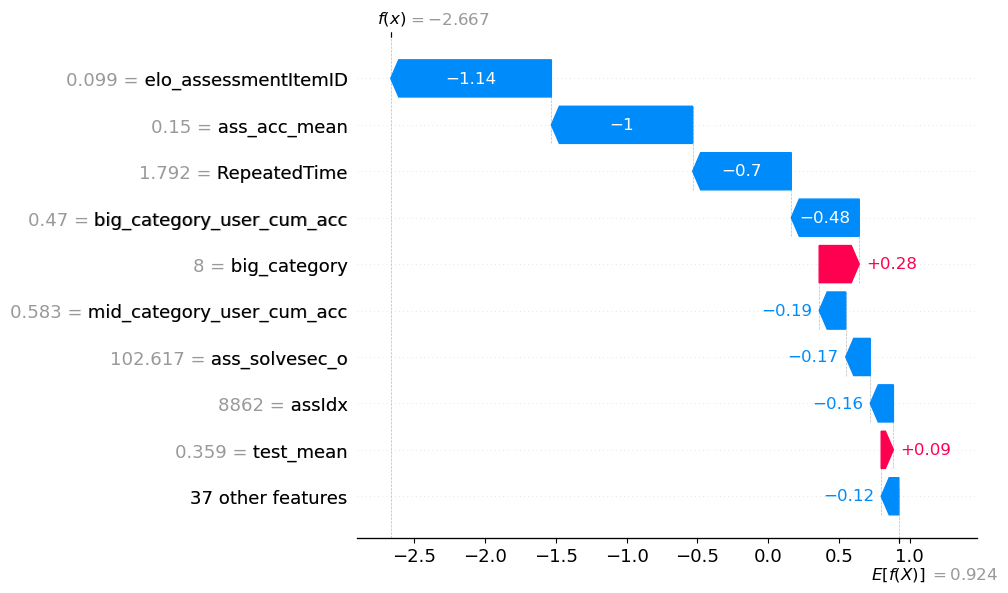

In [60]:
explainer = TreeExplainer(model4)
sv = explainer(x_valid2[FEATS])
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=x_valid2[FEATS].values, 
                  feature_names=FEATS)
idx = 0
waterfall(exp[idx])

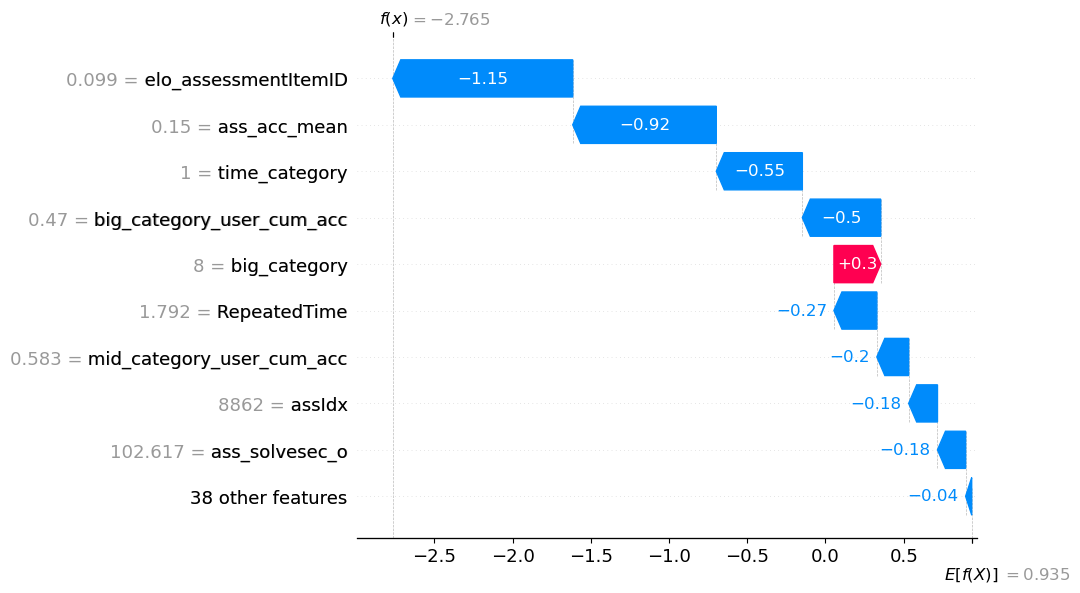

In [57]:
explainer = TreeExplainer(model4)
sv = explainer(x_valid2[FEATS])
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=x_valid2[FEATS].values, 
                  feature_names=FEATS)
idx = 0
waterfall(exp[idx])

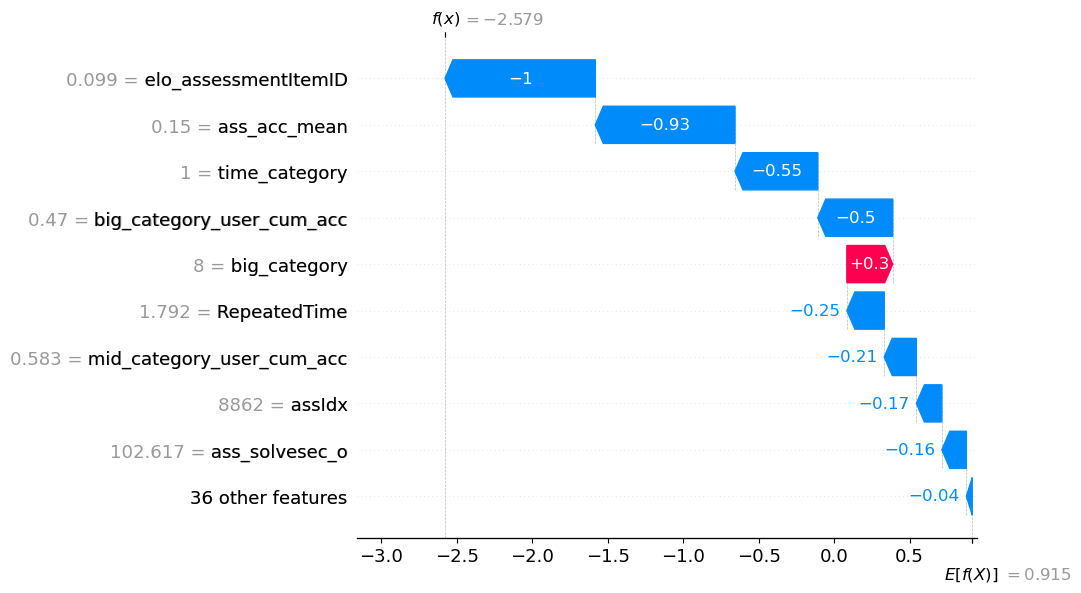

In [54]:
explainer = TreeExplainer(model4)
sv = explainer(x_valid2[FEATS])
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=x_valid2[FEATS].values, 
                  feature_names=FEATS)
idx = 0
waterfall(exp[idx])

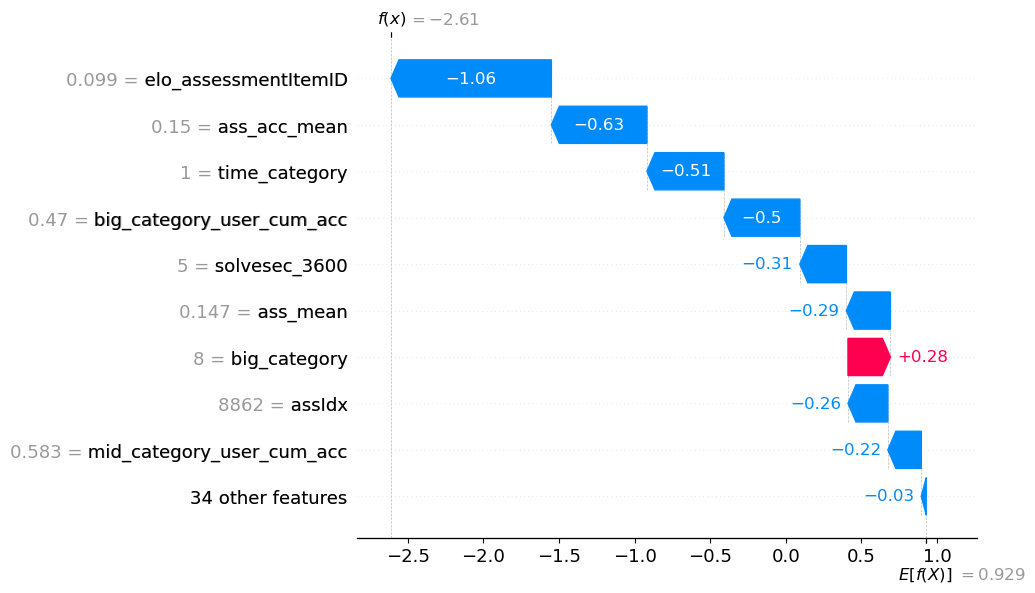

In [37]:
explainer = TreeExplainer(model)
sv = explainer(x_valid2[FEATS])
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=x_valid2[FEATS].values, 
                  feature_names=FEATS)
idx = 0
waterfall(exp[idx])

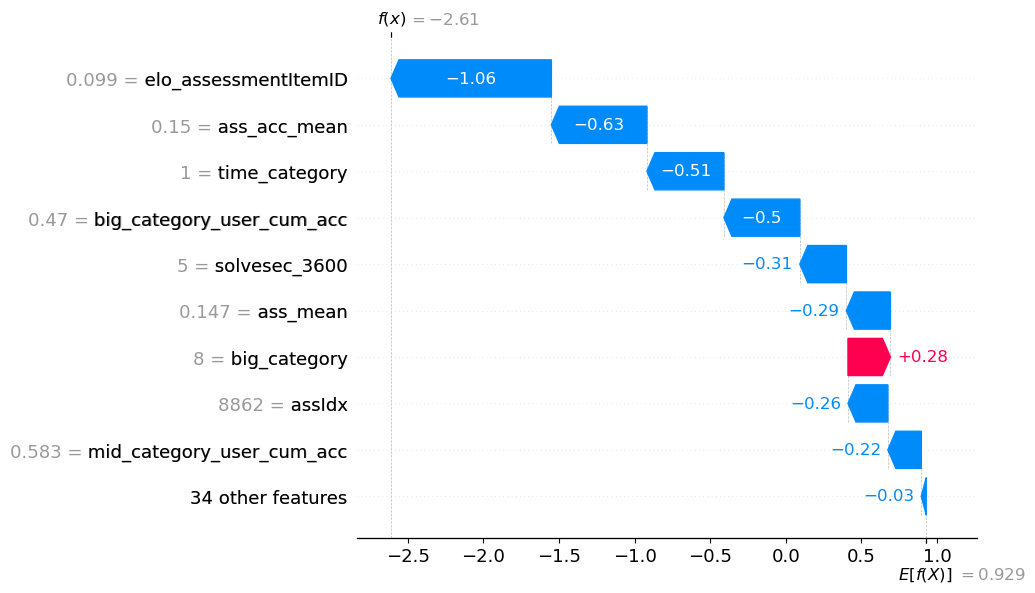

In [37]:
explainer = TreeExplainer(model)
sv = explainer(x_valid2[FEATS])
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=x_valid2[FEATS].values, 
                  feature_names=FEATS)
idx = 0
waterfall(exp[idx])

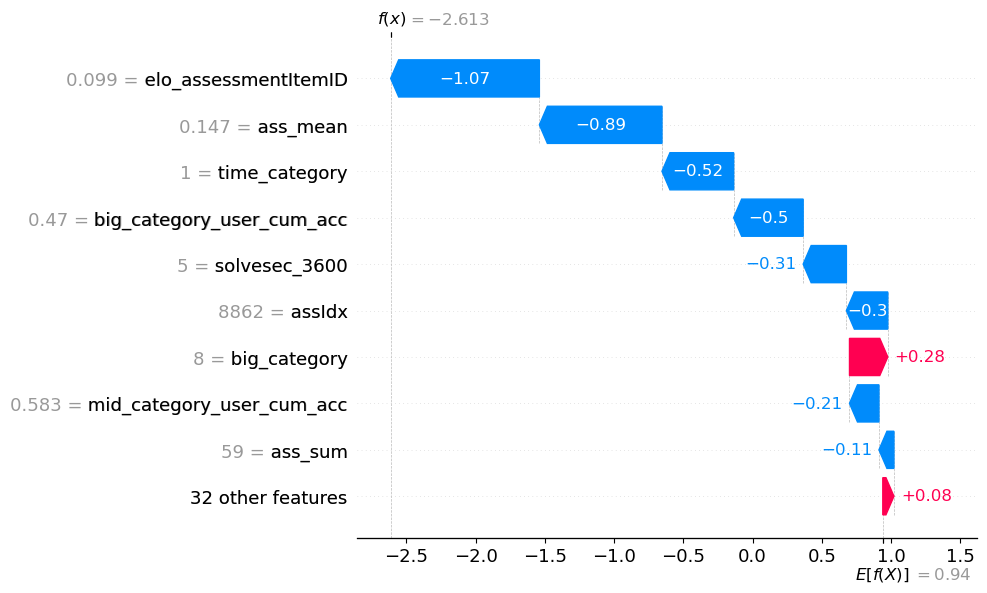

In [34]:
explainer = TreeExplainer(model)
sv = explainer(x_valid2[FEATS])
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=x_valid2[FEATS].values, 
                  feature_names=FEATS)
idx = 0
waterfall(exp[idx])

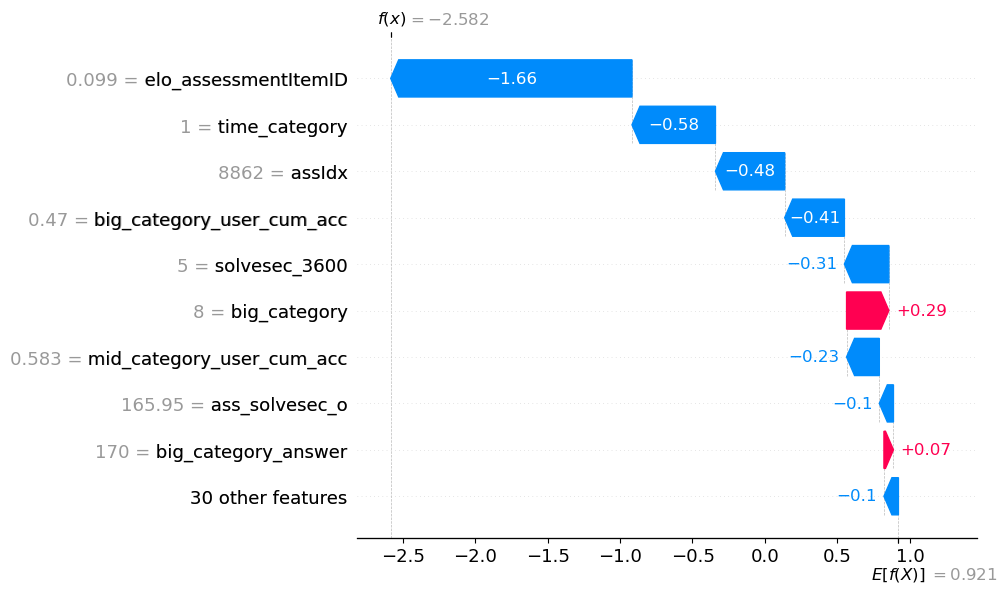

In [32]:
explainer = TreeExplainer(model)
sv = explainer(x_valid2[FEATS])
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=x_valid2[FEATS].values, 
                  feature_names=FEATS)
idx = 0
waterfall(exp[idx])

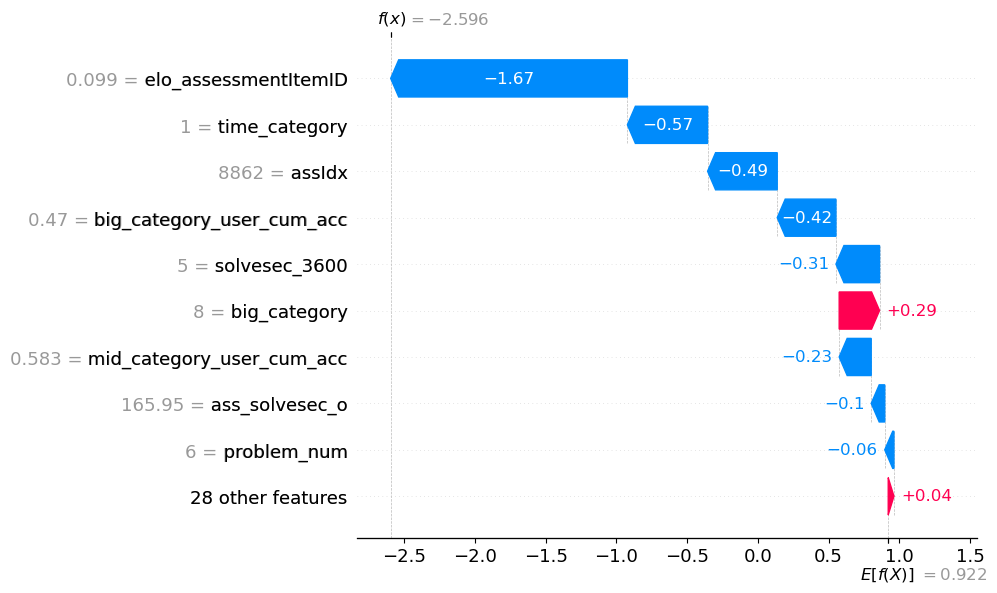

In [30]:
explainer = TreeExplainer(model)
sv = explainer(x_valid2[FEATS])
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=x_valid2[FEATS].values, 
                  feature_names=FEATS)
idx = 0
waterfall(exp[idx])

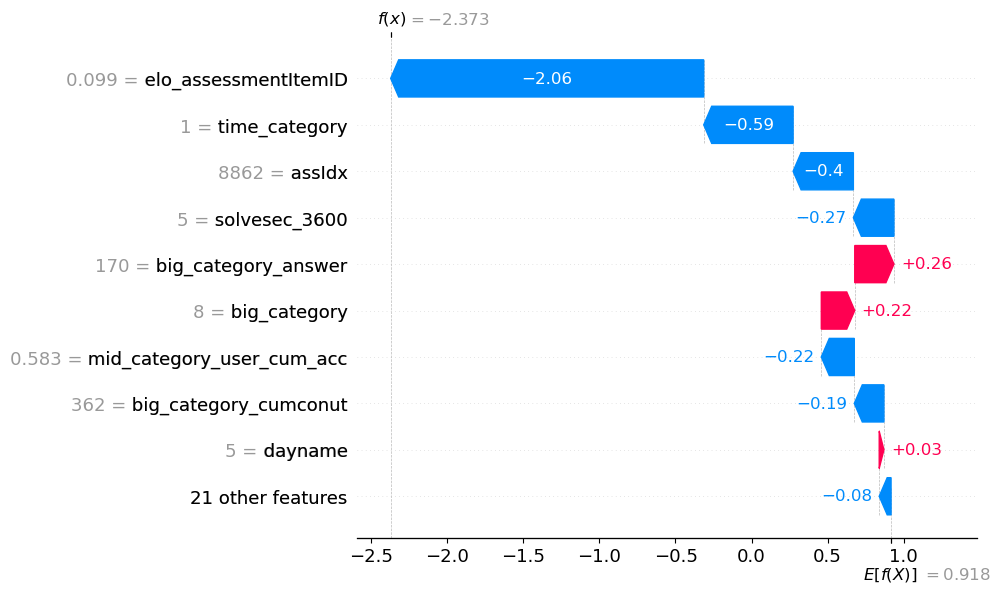

In [26]:
explainer = TreeExplainer(model)
sv = explainer(x_valid2[FEATS])
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=x_valid2[FEATS].values, 
                  feature_names=FEATS)
idx = 0
waterfall(exp[idx])

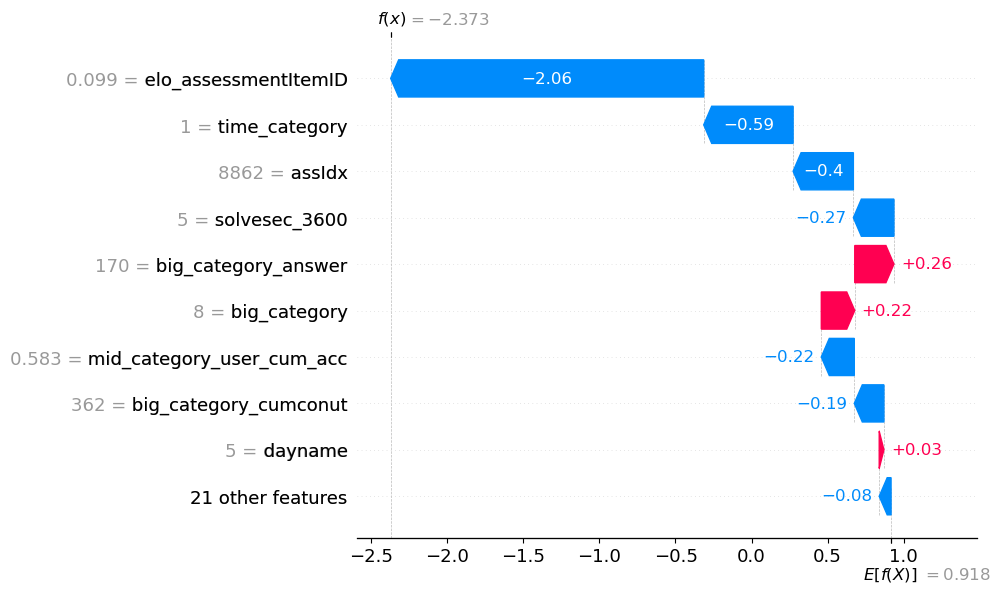

In [26]:
explainer = TreeExplainer(model)
sv = explainer(x_valid2[FEATS])
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=x_valid2[FEATS].values, 
                  feature_names=FEATS)
idx = 0
waterfall(exp[idx])

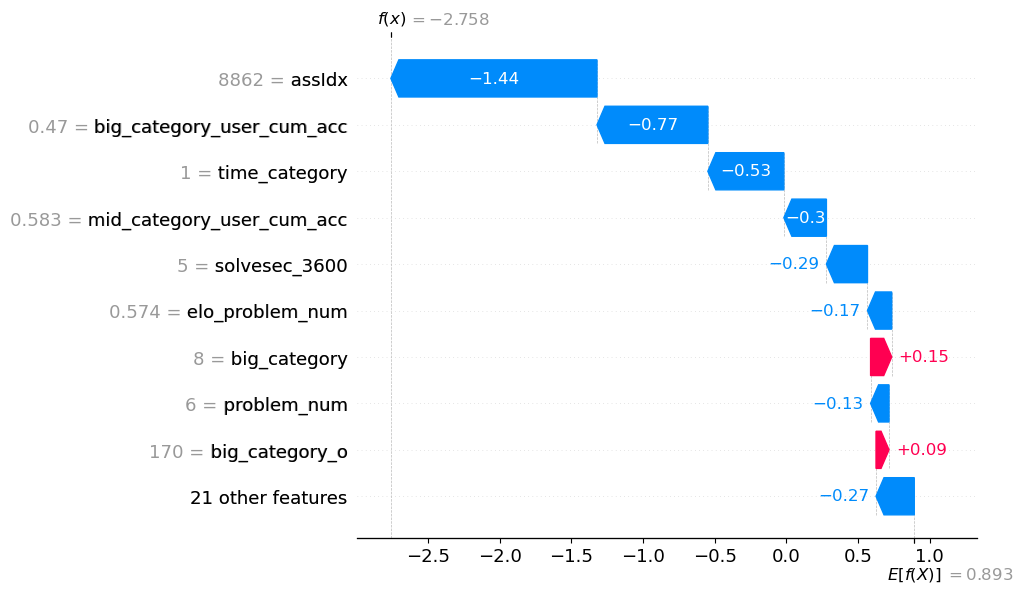

In [24]:
explainer = TreeExplainer(model)
sv = explainer(x_valid2[FEATS])
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=x_valid2[FEATS].values, 
                  feature_names=FEATS)
idx = 0
waterfall(exp[idx])

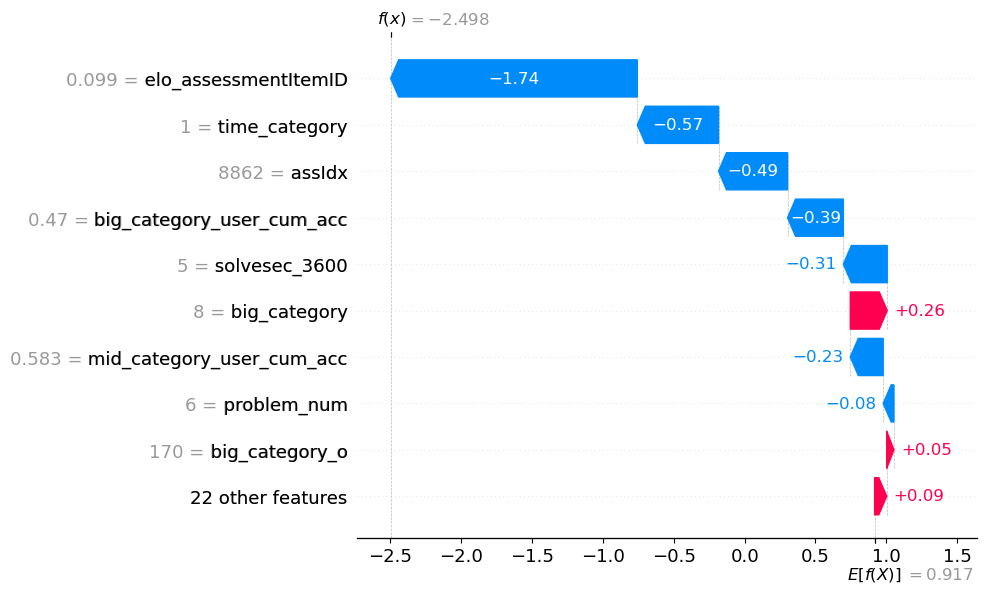

In [22]:
explainer = TreeExplainer(model)
sv = explainer(x_valid2[FEATS])
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=x_valid2[FEATS].values, 
                  feature_names=FEATS)
idx = 0
waterfall(exp[idx])

In [21]:
perm = PermutationImportance(
    model, scoring="roc_auc", n_iter=1, random_state=42, cv=None, refit=False
).fit(x_valid2[FEATS], y_valid2)
eli5.show_weights(perm, top=len(FEATS), feature_names=FEATS)

TypeError: estimator should be an estimator implementing 'fit' method, <lightgbm.basic.Booster object at 0x7fefce864bb0> was passed

In [ ]:
# Hyper parameter 설정
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "dart",  # dart
    "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
    "metric": "auc",
}

### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'assess_count',
         'elo_assessmentItemID',
         'elo_problem_num',
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM 기존 user_acc 제외 lr 0.023 dart] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\nFEATS='{using_feats}'.split(', ')]"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid1 = lgb.Dataset(x_valid1[FEATS], y_valid1)
lgb_x_valid2 = lgb.Dataset(x_valid2[FEATS], y_valid2)

with mlflow.start_run(run_name=title, description=desc) as run:
    model = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid1, lgb_x_valid2],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds1 = model.predict(x_valid1[FEATS])
    preds2 = model.predict(x_valid2[FEATS])
    acc = accuracy_score(y_valid2, np.where(preds2 >= 0.5, 1, 0))
    auc1 = roc_auc_score(y_valid1, preds1)
    auc2 = roc_auc_score(y_valid2, preds2)
    print(f'VALID1 AUC : {auc1}, VALID2 AUC : {auc2}, ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc2)
    mlflow.log_metric("VAL Set SEED",SEED)
    model_run_id=run.info.run_id
    post_slack("done")
    print(f"{model_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')